### PaddleOCR Pipeline

Цель проекта:
- DJVU → PNG → PaddleOCR (GPU) → LM Studio (локальная LLM) / API Gemeni → PDF с невидимым текстовым слоем OCR.

### Install PaddleOCR

https://github.com/PaddlePaddle/PaddleOCR/blob/main/readme/README_ru.md
https://www.paddleocr.ai/latest/en/version3.x/pipeline_usage/OCR.html

Руководству по установке
https://www.paddlepaddle.org.cn/en/install/quick?docurl=/documentation/docs/en/develop/install/pip/windows-pip_en.html


- J:\Python\.torch-env\Scripts\Activate


Версия CUDA в PyTorch: 12.9
- python -m pip install paddlepaddle-gpu==3.2.2 -i https://www.paddlepaddle.org.cn/packages/stable/cu129/

Verify installation
- paddle.utils.run_check()

#### Если вы хотите использовать только базовую функцию распознавания текста (возвращает координаты и содержание текста, включая серию PP-OCR)
- python -m pip install paddleocr
- python -m pip install "paddleocr[all]"
- pip install --upgrade pymupdf

In [ ]:
# %% [2] Импорты и настройки устройства (GPU если есть)

import os
from tqdm import tqdm
import fitz  # pymupdf
import paddle
# import io
# import math
# import time
# import glob
# from PIL import Image

paddle.utils.run_check()
print(fitz.__doc__)

# Попытка выставить GPU; если не доступен — автоматически упадёт на CPU.
try:
    paddle.set_device('gpu')
    print("paddle device set to GPU:", paddle.get_device())
except Exception as e:
    paddle.set_device('cpu')
    print("GPU недоступен, используем CPU. Причина:", e)

# Проверка компиляции с CUDA
print("Is paddle using GPU? ->", paddle.device.is_compiled_with_cuda())


# %% [3] Параметры: файлы и папки — поменяй под себя
DJVU_FILE = "book.djvu"            # <-- путь к входному djvu
OUT_IMAGES = "images"
OUT_TEST = "image_test"               # куда сохраняем PNG
OUT_PRE = "images_pre"             # (опционально) предобработанные
OUT_TEXT_RAW = "pages_raw_text"    # текст после OCR
OUT_TEXT_CORR = "pages_corr_text"  # текст после LLM
OUT_PDF = "book_with_ocr.pdf"      # итоговый PDF

os.makedirs(OUT_IMAGES, exist_ok=True)
os.makedirs(OUT_PRE, exist_ok=True)
os.makedirs(OUT_TEXT_RAW, exist_ok=True)
os.makedirs(OUT_TEXT_CORR, exist_ok=True)

## Этап 1: Перевод PDF -> PNG

В коде можно выбрать качество - 300 dpi

Проще сделать в WinDjvu

In [ ]:
# PDF -> PNG через PyMuPDF
# Перевод DJVU → PDF делался в "DjVuLibre DjView" (экспорт в PDF)

# Параметры
PDF_FILE = "Fiz_idealizm_2017.pdf"        # путь к PDF
OUT_IMAGES = "images"        # папка для PNG
os.makedirs(OUT_IMAGES, exist_ok=True)

# открываем PDF
doc = fitz.open(PDF_FILE)
print(f"Количество страниц: {doc.page_count}")

# рендер каждой страницы в PNG
for i, page in enumerate(doc, start=1):
    # zoom увеличивает DPI: 2.0 ~ 300 dpi, можно регулировать
    zoom = 2.0
    mat = fitz.Matrix(zoom, zoom)
    pix = page.get_pixmap(matrix=mat)

    out_path = os.path.join(OUT_IMAGES, f"page_{i:04d}.png")
    pix.save(out_path)
    print(f"Сохранили страницу {i} -> {out_path}")

doc.close()
print("Все страницы успешно сохранены в PNG")


## Этап 2: Детекция и распознавание текста
### PNG → PaddleOCR → TXT

### det_limit_side_len (или text_det_limit_side_len в старых версиях/аргументах) — это ограничение максимального размера картинки перед тем, как она попадет в нейросеть для поиска текста.
Это самый важный параметр для качества распознавания мелкого текста.
Как это работает:
Представьте, у вас есть скан документа А4 в высоком качестве (например, высота 3500 пикселей).
Нейросеть (DBNet) не может "съесть" картинку любого размера, ей нужно привести её к некому стандарту.
Если det_limit_side_len=960 (стандартное значение):
Paddle берет вашу картинку 3500px.
Видит, что 3500 > 960.
Уменьшает (сжимает) картинку так, чтобы длинная сторона стала 960px.
Результат: Картинка уменьшилась в ~3.5 раза.
Проблема: Мелкий текст при таком сжатии превращается в "кашу". Детектор его просто не увидит или пропустит куски.
Если det_limit_side_len=2500 (или больше):
Paddle видит картинку 3500px.
Уменьшает её до 2500px.
Это гораздо более щадящее сжатие. Мелкие буквы остаются четкими.

In [13]:
# Инициализация экземпляра PaddleOCR
#  "return_word_box": true - ВКЛЮЧАЕМ для точного позиционирования в PDF - не работает !

from paddleocr import PaddleOCR
import os
from tqdm import tqdm
# from transliterate import translit
# import pymorphy3

ocr = PaddleOCR(
    lang='ru',
    device="gpu:0",

    # Отключаем лишние "тяжелые" модули для скорости, если сканы ровные
    use_textline_orientation=False,        # Включайте True, только если текст может быть перевернут на 180°
    use_doc_orientation_classify=False, 
    use_doc_unwarping=False,    # Выпрямление (нужно только для фото кривых страниц)
    
    # --- НАСТРОЙКИ ДЕТЕКЦИИ ---
    text_det_box_thresh=0.5,    # <--- ИСПРАВЛЕНО: Правильное имя для box_thresh
    text_det_thresh=0.3,        # (Опционально) Порог бинаризации пикселей (стандарт 0.3)
    text_det_unclip_ratio=1.5,  # (Опционально) Расширение границ (стандарт 1.5)

    # --- РАЗМЕР КАРТИНКИ ---
    text_det_limit_side_len = 3000, # минимальное число для корректной детекции
    
    # det_limit_side_len = 2000, - устарело
    # text_det_limit_side_len=960,
    # text_detection_model_name="PP-OCRv5_mobile_det",
    # text_recognition_model_name="cyrillic_PP-OCRv3_mobile_rec", # cyrillic_PP-OCRv5_mobile_rec_infer
)

Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Ritz\.paddlex\official_models\PP-OCRv5_server_det`.
j:\Python\.paddle-gpu\Lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('eslav_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Ritz\.paddlex\official_models\eslav_PP-OCRv5_mobile_rec`.


### Этап 2.1: OCR одной картинки:

In [14]:
# Test - инференс OCR на примере одного изображения

IMAGE_PATH = "p0001.png"
result_test = ocr.predict(input=IMAGE_PATH)

# Визуализация результатов и сохранение в формате JSON
for res in result_test:
    # res.print()
    res.save_to_img("")
    res.save_to_json("")

# Извлекаем текст
texts = res.get("rec_texts", [])
# words = res.get("text_word", [])
full_text = "\n".join(texts)
texts

Resized image size (4419x3000) exceeds max_side_limit of 4000. Resizing to fit within limit.


['HAYKA',
 'CCCP',
 'Чере3',
 'тернии',
 ',',
 '№ 42',
 'звездам',
 'K',
 'A.C.СoHH',
 'ФИЗИЧЕСКИЙ',
 'ИДЕАЛИЗМ',
 'ДРАМАТИЧЕСКИЙ',
 'ПУТЬ ВНЕДРЕНИЯ',
 'РЕВОЛЮЦИОННЫХ ИДЕЙ',
 'ФИЗИКИ НАЧАЛА ХХ ВЕКА',
 'на примере',
 'исТОРиИ',
 '',
 'противостояния',
 'в советсной физике',
 'URSS']

### Этап 2.2: Цикл OCR по всем картинкам папки:

- берёт все PNG из папки folder/

- прогоняет каждую через ocr.predict()

- автоматически собирает список

In [ ]:
# Прогон всех PNG через OCR и сохранение raw текстов
OUT_IMAGES = "images_raw"  # Папка с изображениями
OUT_TEXT_RAW = "images_raw_text"  # Папка для сохранения результатов

# проверка: есть ли файлы в каталоге
if os.path.exists(OUT_IMAGES) and len(os.listdir(OUT_IMAGES)) > 0:
    try:
        # прогрессбар — просто оборачиваем вызов predict в tqdm
        result = []
        for img in tqdm(os.listdir(OUT_IMAGES), desc="OCR"):
            path = os.path.join(OUT_IMAGES, img)
            if os.path.isfile(path):
                result.extend(ocr.predict(input=path))

        # сохраняем все в одну папку
        for res in result:
            res.save_to_img(OUT_TEXT_RAW)
            res.save_to_json(OUT_TEXT_RAW)

    except Exception as e:
        print(f"Ошибка: {e}")
else:
    print("Файлы не найдены.")

## Этап 3. Создание PDF файла
### PDF со скрытым OCR-слоем (texts + boxes)

- 1 px картинки = 1 pt PDF → координаты совпадают идеально
-  rec_boxes = [x1, y1, x2, y2]
-  render_mode=3 → текст невидим, но searchable
-  Подбор fontsize по ширине бокса, с ограничением по высоте

#### Этап 3.1: Создание PDF файла из одного изображения:

In [ ]:
# V.0 - Создание PDF файла из одного изображения

import json
import fitz  # PyMuPDF
import os

FONT_PATH = "C:/Windows/Fonts/arial.ttf"


def pdf_with_ocr(img_path, json_path, out_pdf, font_path=FONT_PATH):
    if not os.path.exists(font_path):
        raise FileNotFoundError(f"Шрифт не найден: {font_path}")

    # --- 1. Загружаем OCR-данные ---
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    texts = data["rec_texts"]
    boxes = data["rec_boxes"]

    assert len(texts) == len(boxes), "texts и boxes должны быть одинаковой длины"

    # --- 2. Получаем реальные размеры изображения (в пикселях) ---
    pix = fitz.Pixmap(img_path)
    width_px, height_px = pix.width, pix.height
    del pix

    # --- 3. Создаём PDF страницу ровно под размер картинки ---
    doc = fitz.open()
    page = doc.new_page(width=width_px, height=height_px)

    # --- 4. Вставляем изображение фоном ---
    page.insert_image(
        fitz.Rect(0, 0, width_px, height_px),
        filename=img_path
    )

    # --- 5. Регистрируем шрифт ---
    font_name = "ocrfont"
    page.insert_font(fontname=font_name, fontfile=font_path)
    calc_font = fitz.Font(fontfile=font_path)

    # --- 6. Вставляем невидимый текст ---
    for text, box in zip(texts, boxes):
        if not text.strip():
            continue

        x1, y1, x2, y2 = box
        box_w = x2 - x1
        box_h = y2 - y1

        if box_w <= 0 or box_h <= 0:
            continue

        # Подбор размера шрифта по ширине
        text_len_1pt = calc_font.text_length(text, fontsize=1)
        if text_len_1pt == 0:
            continue

        fontsize = min(box_w / text_len_1pt, box_h)

        # insert_text работает от baseline → используем нижний левый угол
        # insert_point = fitz.Point(x1, y2)

        # --- КОРРЕКЦИЯ BASELINE ---
        baseline_shift = box_h * 0.25
        insert_point = fitz.Point(x1, y2 - baseline_shift)

        page.insert_text(
            insert_point,
            text,
            fontname=font_name,
            fontsize=fontsize,
            render_mode=3  # 3 = невидимый (OCR-слой)
        )

    # --- 7. Сохраняем PDF ---
    doc.save(out_pdf)
    doc.close()
    print(f"Сохранено: {out_pdf}")


# ---------------- ЗАПУСК ----------------
pdf_with_ocr(
    img_path="p0001.png",
    json_path="p0001_res.json",
    out_pdf="p0001_searchable.pdf"
)


Сохранено: p0001_searchable.pdf


#### Этап 3.2: Объединяем в многостраничный PDF:

- берёт ВСЕ .png и .json из одной папки
- сопоставляет PNG ↔ JSON по имени
- делает ОДИН многостраничный PDF
- использует OCR-слой texts + boxes
- сразу готов для production
- OCR совпадает пиксель-в-пиксель

In [ ]:
# V.3 - Создание PDF файла из нескольких изображений + PNG в JPEG + RESIZE + photo/text pages detection

import os
import json
import io
import fitz
from glob import glob
from PIL import Image

# ---------------- НАСТРОЙКИ ----------------
FONT_PATH = "C:/Windows/Fonts/arial.ttf"

DATA_DIR = "image_test_out"
OUT_PDF = "final_ocr_document_det_100_binary.pdf"


MAX_SIDE = 100     # максимальная сторона изображения (px), минимум 2000 для страниц с картинками
JPEG_QUALITY = 85   # качество JPEG
BASELINE_K = 0.25   # сдвиг baseline (25% высоты бокса)


# ---------- БИНАРИЗАЦИЯ СТРАНИЦЫ ----------
def preprocess_page(img_path):
    import cv2, numpy as np
    from skimage.filters import threshold_sauvola

    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    unique = len(np.unique(gray))
    edges = cv2.Canny(gray, 50, 150)
    edge_ratio = edges.mean()

    is_text = unique < 40 and edge_ratio > 0.03

    th = threshold_sauvola(gray, window_size=25, k=0.2)
    bw = (gray > th).astype("uint8") * 255

    # return bw, "binary"

    if is_text:
        th = threshold_sauvola(gray, window_size=25, k=0.2)
        bw = (gray > th).astype("uint8") * 255
        return bw, "binary"
    else:
        return gray, "photo"


# ---------- CCITT-кодер для страниц с текстом ----------
def load_image_as_ccitt_bytes(bw_array):
    img = Image.fromarray(bw_array).convert("1")
    buf = io.BytesIO()
    img.save(buf, format="TIFF", compression="group4")
    return buf.getvalue()


# ---------- PNG → JPEG + downscale ----------
def load_image_as_jpeg_bytes(img_path, max_side=MAX_SIDE, quality=JPEG_QUALITY):
    """
    Возвращает:
    - jpeg_bytes : bytes
    - scale      : коэффициент масштабирования
    - (w, h)     : новый размер изображения
    """
    img = Image.open(img_path).convert("RGB")
    w, h = img.size

    scale = min(1.0, max_side / max(w, h))
    if scale < 1.0:
        new_size = (int(w * scale), int(h * scale))
        img = img.resize(new_size, Image.LANCZOS)

    buf = io.BytesIO()
    img.save(buf, format="JPEG", quality=quality, optimize=True)

    return buf.getvalue(), scale, img.size


# ---------- ДОБАВЛЕНИЕ СТРАНИЦЫ С OCR ----------
def add_page_with_ocr(doc, img_path, json_path):
    # --- OCR данные ---
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    texts = data["rec_texts"]
    boxes = data["rec_boxes"]

    # --- Картинка (JPEG + downscale) ---
    # img_bytes, scale, (w, h) = load_image_as_jpeg_bytes(img_path)

    # --- классификация страницы ---
    page_img, page_type = preprocess_page(img_path)

    if page_type == "binary":
        # текст → CCITT (без downscale!)
        img_bytes = load_image_as_ccitt_bytes(page_img)
        h, w = page_img.shape
        scale = 1.0
    else:
        # фото → JPEG + downscale
        img_bytes, scale, (w, h) = load_image_as_jpeg_bytes(img_path)

    # page = doc.new_page(width=w, height=h)
    # page.insert_image(fitz.Rect(0, 0, w, h), stream=img_bytes)

    # размеры страницы — ВСЕГДА оригинальные
    orig = Image.open(img_path)
    W, H = orig.size

    page = doc.new_page(width=W, height=H)

    # картинку растягиваем на всю страницу
    page.insert_image(
        fitz.Rect(0, 0, W, H),
        stream=img_bytes
    )


    # --- Шрифт ---
    font_name = "ocrfont"
    page.insert_font(fontname=font_name, fontfile=FONT_PATH)
    font = fitz.Font(fontfile=FONT_PATH)

    # --- OCR слой ---
    for text, box in zip(texts, boxes):
        if not text.strip():
            continue

        # масштабируем координаты бокса
        # x1, y1, x2, y2 = [v * scale for v in box]
        x1, y1, x2, y2 = box
        bw, bh = x2 - x1, y2 - y1
        if bw <= 0 or bh <= 0:
            continue

        # подбор шрифта по ширине строки
        tl = font.text_length(text, fontsize=1)
        if tl == 0:
            continue

        fontsize = min(bw / tl, bh)

        # baseline по центру визуально
        baseline_shift = bh * BASELINE_K
        insert_point = fitz.Point(x1, y2 - baseline_shift)

        page.insert_text(
            insert_point,
            text,
            fontname=font_name,
            fontsize=fontsize,
            render_mode=3  # невидимый OCR
        )


# ---------------- СБОР ФАЙЛОВ ----------------
png_files = sorted(glob(os.path.join(DATA_DIR, "*.png")))

pairs = []
for png in png_files:
    base = os.path.splitext(os.path.basename(png))[0]
    json_path = os.path.join(DATA_DIR, f"{base}_res.json")
    if os.path.exists(json_path):
        pairs.append((png, json_path))
    else:
        print(f"⚠ Нет JSON для {png}")

print(f"Страниц: {len(pairs)}")

# ---------------- СОЗДАНИЕ PDF ----------------
doc = fitz.open()

for i, (png, js) in enumerate(pairs, 1):
    print(f"[{i}/{len(pairs)}] {os.path.basename(png)}")
    add_page_with_ocr(doc, png, js)

doc.save(
    os.path.join(DATA_DIR, OUT_PDF),
    deflate=True,
    garbage=4,
    clean=True
)
doc.close()

print(f"\n✅ Готово: {OUT_PDF}")


### Этап 4. Коррекция OCR в gemini-2.0-flash

In [ ]:
### Version.3: Коррекция OCR в gemini-2.0-flash
# II. Постобработка текста в модели gemini-2.0-flash

import google.generativeai as genai
import os

# Не забудь настроить ключ перед вызовом функции
genai.configure(api_key="******")

def fix_ocr_with_llm(rec_texts):
    """
    Исправление OCR списка строк через Google Gemini 1.5 Flash.
    Гарантирует сохранение количества строк для маппинга координат.
    """
    
    # 1. Инициализация модели
    # Flash идеальна: быстрая, дешевая и с большим контекстным окном
    model = genai.GenerativeModel("gemini-2.0-flash")
    # model = genai.GenerativeModel("gemini-2.0-flash-lite")

    # Если результат плохой, попробуйте более умную версию
    # model = genai.GenerativeModel("gemini-2.5-flash")

    # 2. Подготовка текста
    input_text = "\n".join(rec_texts)
    input_count = len(rec_texts)

    # 3. Промпт (усилен для строгого соблюдения структуры)
    prompt = f"""
Ты — профессиональный корректор OCR. Твоя задача — исправить ошибки распознавания в тексте.

ВХОДНЫЕ ДАННЫЕ:
Список из {input_count} строк.

ИНСТРУКЦИИ:
1. Исправь орфографические ошибки, "битые" символы и смешение латиницы с кириллицей (например, 'MOSKBA' -> 'МОСКВА', 'XХ bека' -> 'XX века').
2. СТРОГО СОХРАНЯЙ КОЛИЧЕСТВО СТРОК. На входе {input_count} строк -> на выходе должно быть ровно {input_count} строк.
3. Не объединяй и не разбивай строки. Каждая строка должна соответствовать своей оригинальной позиции.
4. Если строка выглядит как мусор и не поддается восстановлению — оставь её как есть.
5. Не добавляй никаких комментариев, markdown-разметки (```), вступлений. Только чистый текст.
6. Цифры оставь как есть.
7. Если нужно добавить слова, то добавляй буквы слова внутрь одного из соседних с ним (например, ['тернии', 'звездам'] -> ['тернии', 'к звездам'])
8. Не делай перевод аббревиатур на русский язык.

ТЕКСТ ДЛЯ ИСПРАВЛЕНИЯ:
{input_text}
"""

    try:
        # 4. Генерация
        response = model.generate_content(
            prompt,
            generation_config=genai.types.GenerationConfig(
                temperature=0.1, # Минимальная креативность для точности
            )
        )
        
        fixed_text = response.text.strip()

        # Удаляем markdown обрамление, если Gemini его добавил (```text ... ```)
        if fixed_text.startswith("```"):
            lines = fixed_text.splitlines()
            # Обычно первая строка ```text, последняя ```. Убираем их.
            if len(lines) >= 2:
                if lines[0].startswith("```"): lines = lines[1:]
                if lines[-1].startswith("```"): lines = lines[:-1]
            fixed_text = "\n".join(lines)

        # 5. Преобразование обратно в список
        fixed_list = fixed_text.split("\n")
        
        # Очистка от пробелов по краям строк
        fixed_list = [line.strip() for line in fixed_list]

        # 6. ВАЖНАЯ ПРОВЕРКА (Safety check)
        # Если количество строк не совпадает, мы сломаем PDF (координаты сдвинутся).
        # В таком случае лучше вернуть оригинал.
        if len(fixed_list) != input_count:
            print(f"[WARN] LLM вернула {len(fixed_list)} строк вместо {input_count}. Используем оригинал.")
            # Попытка спасти ситуацию: если разница в пустых строках в конце
            while len(fixed_list) < input_count:
                fixed_list.append("") # Добиваем пустыми
            if len(fixed_list) > input_count:
                fixed_list = fixed_list[:input_count] # Обрезаем лишнее
            
            # Если всё равно структура подозрительная, лучше вернуть rec_texts
            # return rec_texts 
            return fixed_list # Или возвращаем "подогнанный" список

        return fixed_list

    except Exception as e:
        print(f"[ERROR] Ошибка при запросе к Gemini: {e}")
        return rec_texts # Возвращаем исходный текст при ошибке
    


# ---------------- LLM Correction of OCR text from PaddleOCR .json file ------------------------

# One page OCR text correction
with open("page_0001_res.json", "r", encoding="utf-8") as f:
    data = json.load(f)

rec_texts = data["rec_texts"]
print(len(rec_texts))

fixed_texts = fix_ocr_with_llm(rec_texts)
print(len(fixed_texts))


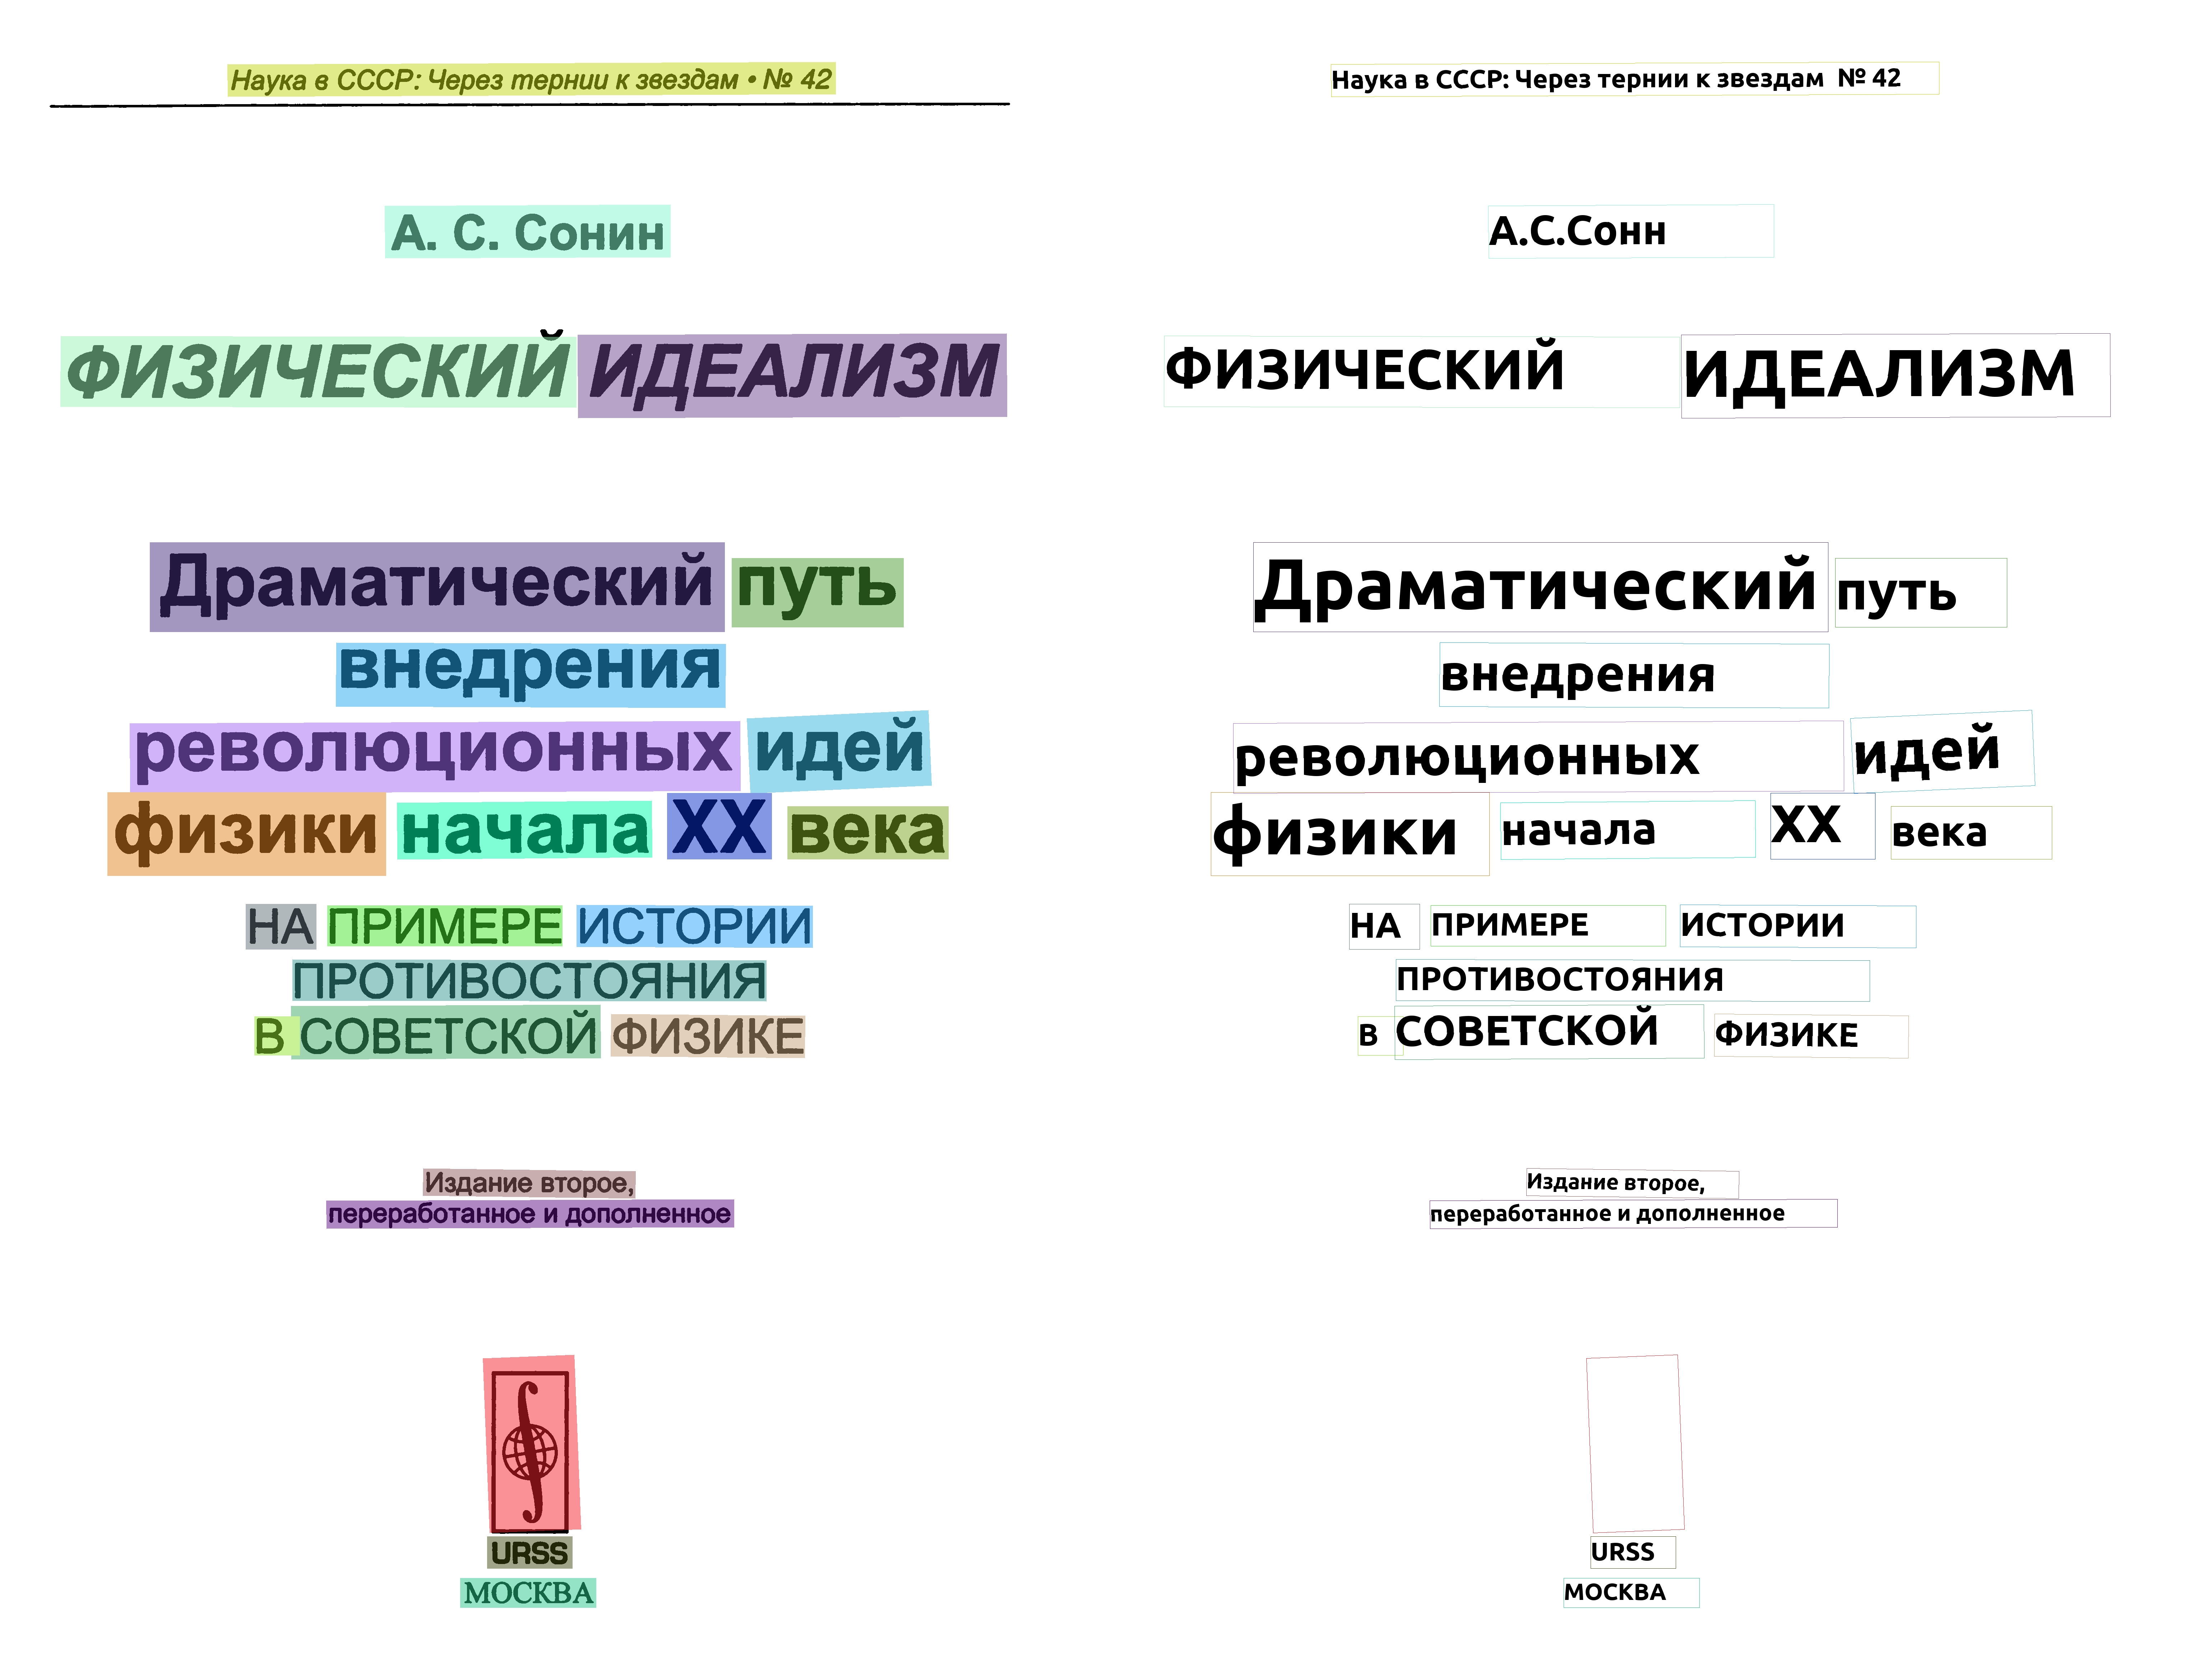